# Store Sales Forecasting Project

## Objective of the Project

The objective of this project is to develop a time-series forecasting model that predicts daily unit sales for thousands of products across multiple stores of Corporación Favorita. Using historical sales data, store and product information, and promotion details, the model aims to provide accurate sales estimates, with performance measured by the Root Mean Squared Logarithmic Error (RMSLE).

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
import warnings
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
stores=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
oil=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
holidays=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
transactions=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
submission=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')

## Exploratory Data Analysis
In this phase, we explored all the datasets for the Store Sales Time Series Forecasting project to understand their structure and contents. For each dataset (train, test, stores, oil, holidays, transactions, and submission), we reviewed the shape, data types, missing values, and sample rows. This initial exploration provided insight into data quality and helped guide the preprocessing and modeling steps.

In [3]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
train.shape

(3000888, 6)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [6]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [7]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [8]:
test.shape

(28512, 5)

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [10]:
test.isnull().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [11]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [12]:
stores.shape

(54, 5)

In [13]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [14]:
stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [15]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [16]:
oil.shape

(1218, 2)

In [17]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [18]:
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [19]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [20]:
holidays.shape

(350, 6)

In [21]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [22]:
holidays.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [23]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [24]:
transactions.shape

(83488, 3)

In [25]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [26]:
transactions.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [27]:
submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [28]:
submission.shape

(28512, 2)

In [29]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28512 non-null  int64  
 1   sales   28512 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 445.6 KB


In [30]:
submission.isnull().sum()

id       0
sales    0
dtype: int64

## Data Visualization
Store distrubutions across cities, states, types and clusters is uneven, meaning some categories dominate while others are sparse. Theses diiffernces will affect the stability of statistical patterns and the performance of predictive models.

In [31]:
# Plots the value counts of a column with a custom palette and label rotation
def plot_stats(df, column, ax, color, angle):
    count_classes = df[column].value_counts()
    ax = sns.barplot(x=count_classes.index, y=count_classes, ax=ax, palette=color)
    ax.set_title(column.upper(), fontsize=18)
    for tick in ax.get_xticklabels():
        tick.set_rotation(angle)

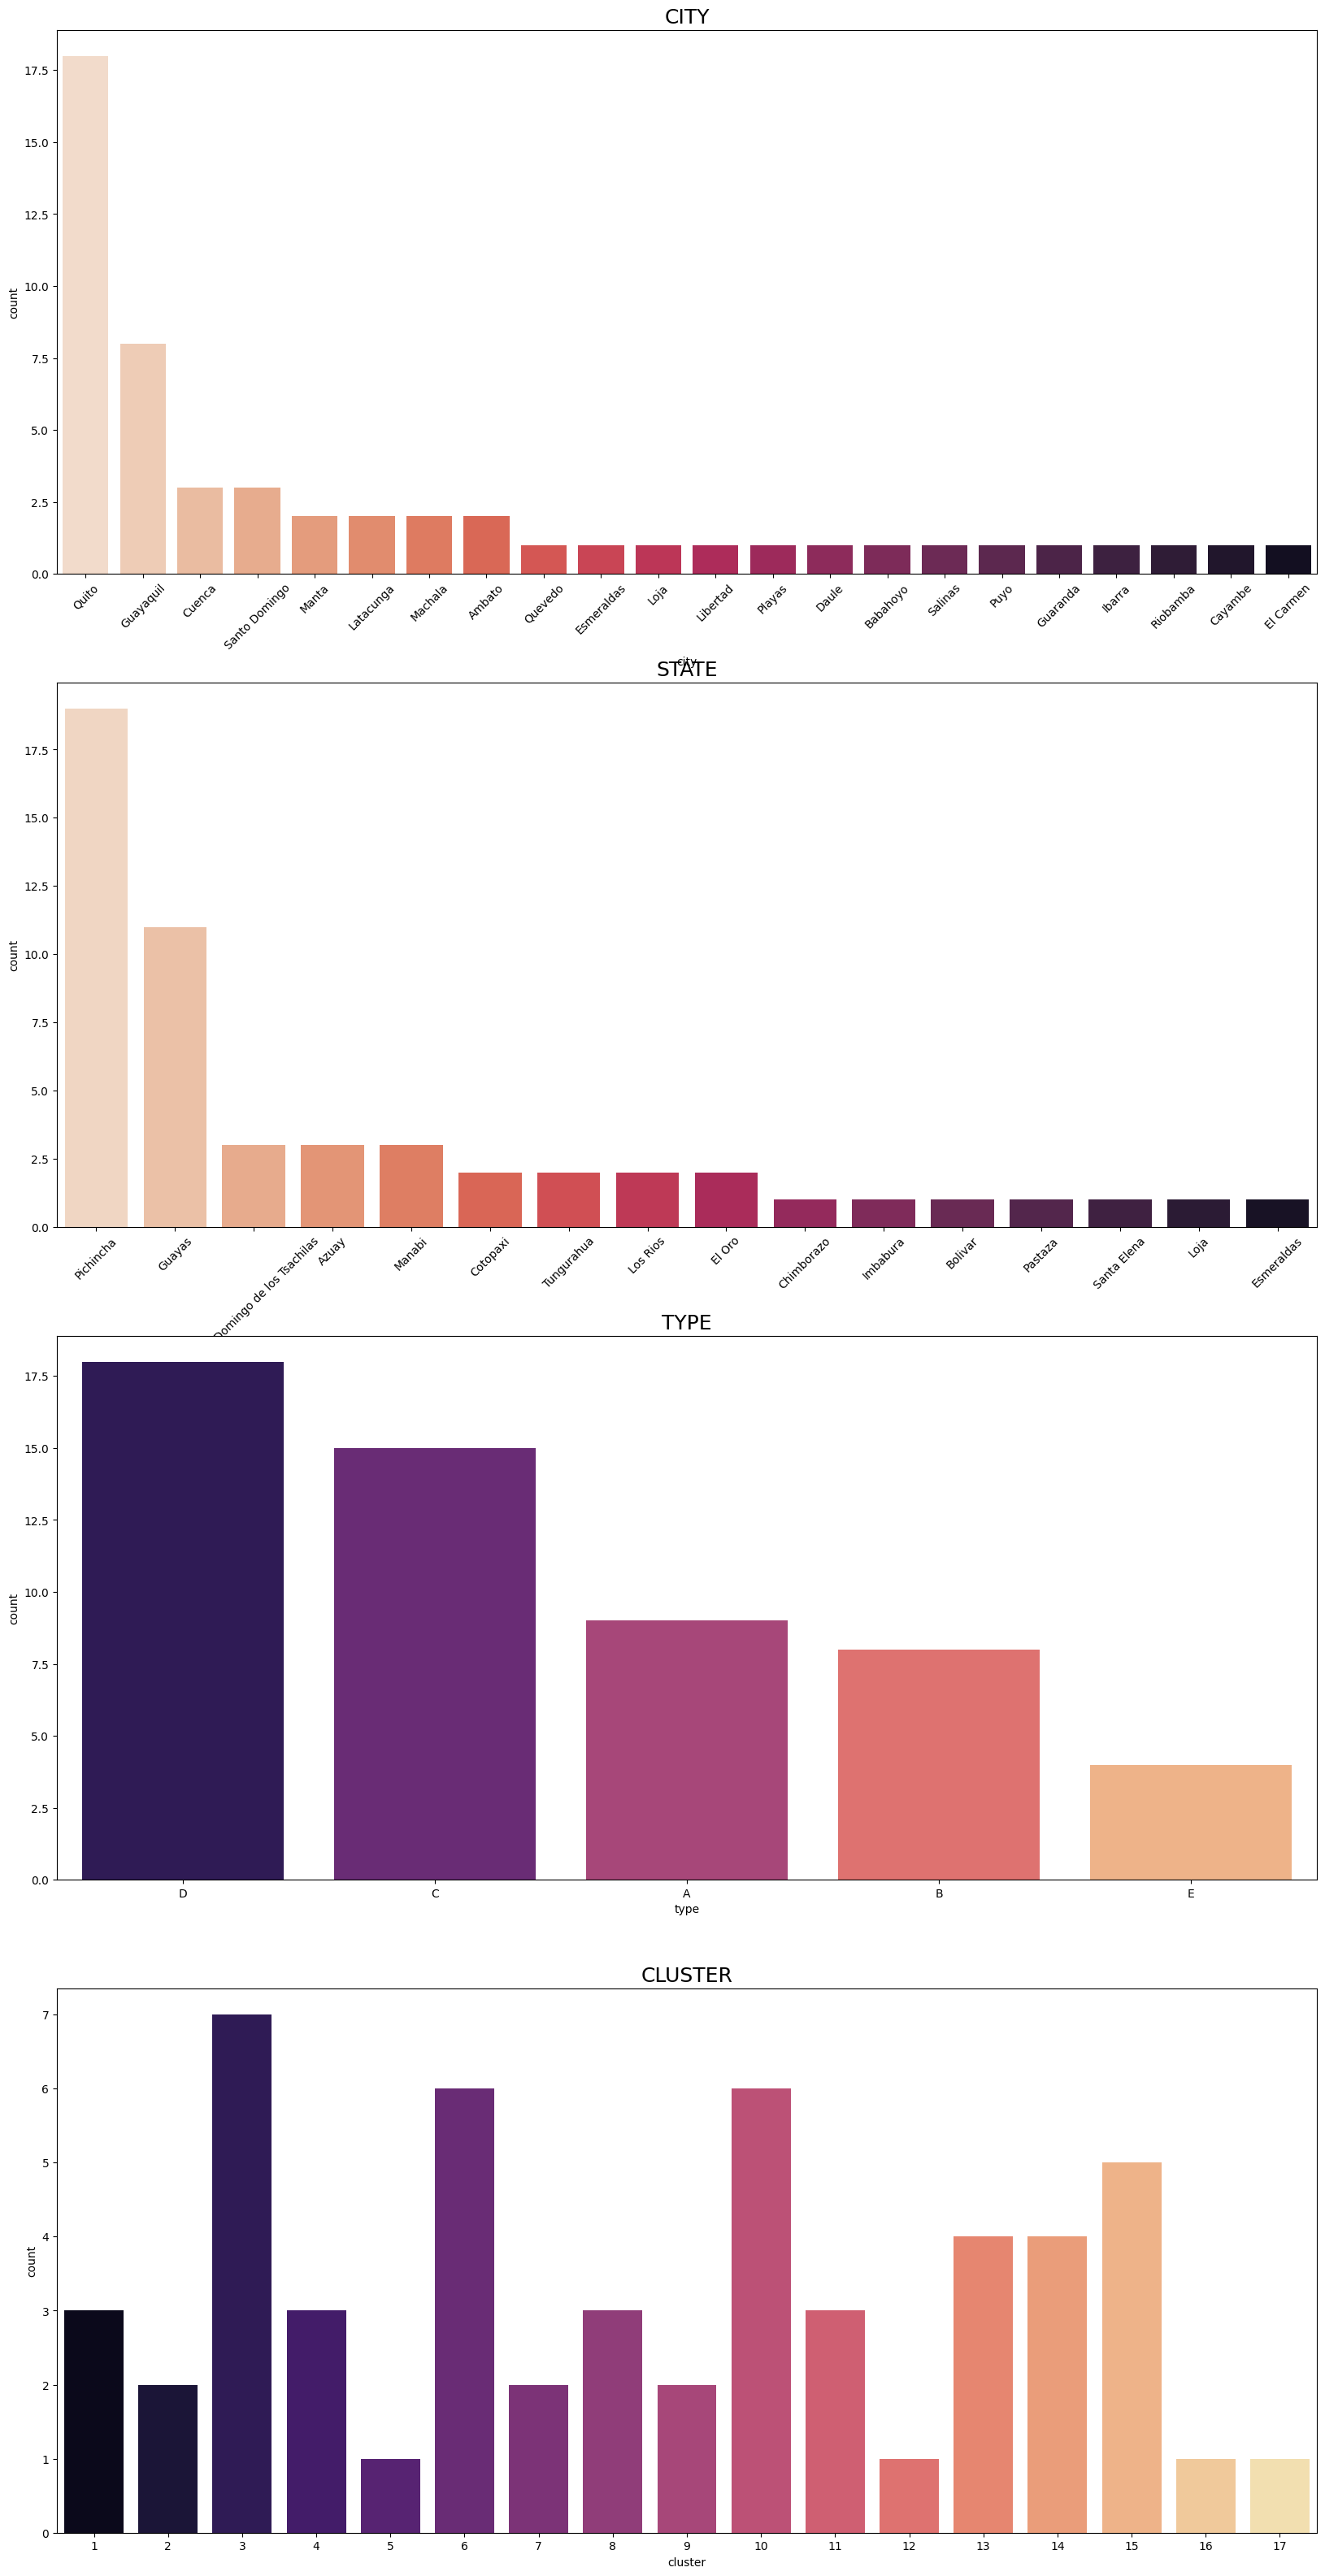

In [32]:
# Plot category distributions for selected store features.
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20,40))
plot_stats(stores, "city", axes[0], "rocket_r", 45)
plot_stats(stores, "state", axes[1], "rocket_r", 45)
plot_stats(stores, "type", axes[2], "magma", 0)
plot_stats(stores, "cluster", axes[3], "magma", 0)
plt.show()

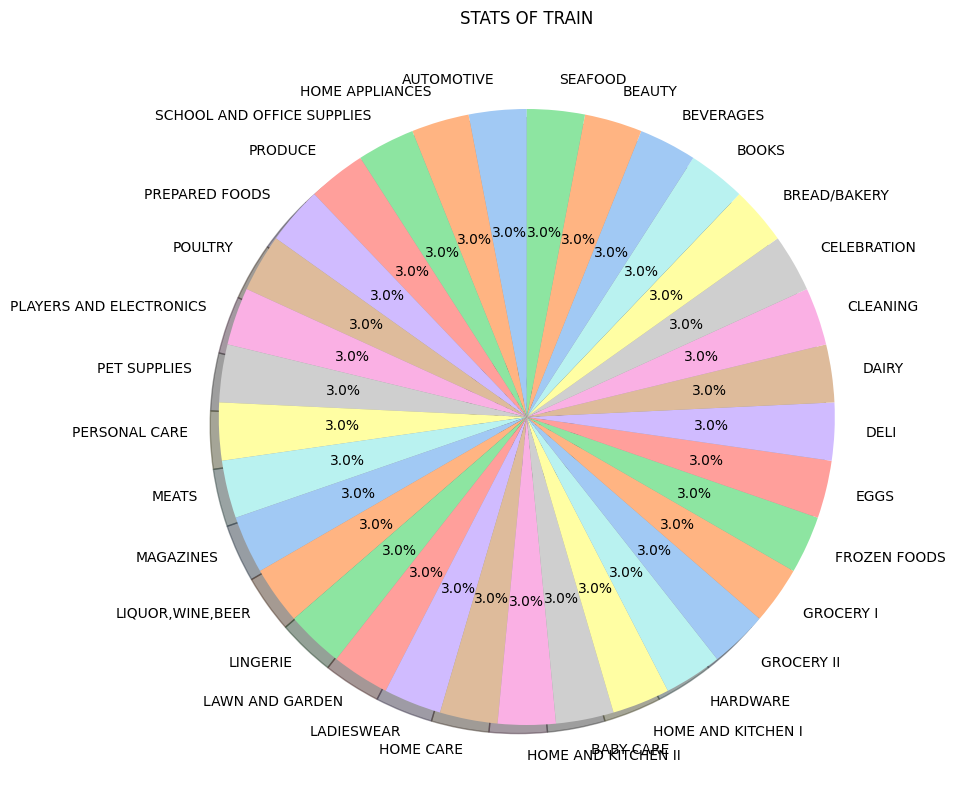

In [33]:
# Visualize the distribution of product families in the training data using a pie chart.
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
count_classes = train['family'].value_counts()
pastel = sns.color_palette("pastel")
plt.title("Stats of train".upper())
plt.pie(count_classes, labels = count_classes.index, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=pastel)
plt.show()

## Data Processing

In [34]:
# Convert date column to datetime and extract useful time-based features.
train['date']=pd.to_datetime(train['date'])
train['year']=train['date'].dt.year
train['month']=train['date'].dt.month
train['day']=train['date'].dt.day
train['dayofweek']=train['date'].dt.dayofweek
train['is_weekend']=(train['dayofweek'] >= 5).astype(int)

In [35]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,is_weekend
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,0


In [36]:
test['date']=pd.to_datetime(test['date'])
test['year']=test['date'].dt.year
test['month']=test['date'].dt.month
test['day']=test['date'].dt.day
test['dayofweek']=test['date'].dt.dayofweek
test['is_weekend']=(test['dayofweek'] >= 5).astype(int)

In [37]:
test.head()

,id,date,store_nbr,family,onpromotion,year,month,day,dayofweek,is_weekend
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16,2,0
1,3000889,2017-08-16,1,BABY CARE,0,2017,8,16,2,0
2,3000890,2017-08-16,1,BEAUTY,2,2017,8,16,2,0
3,3000891,2017-08-16,1,BEVERAGES,20,2017,8,16,2,0
4,3000892,2017-08-16,1,BOOKS,0,2017,8,16,2,0


In [38]:
oil['date']=pd.to_datetime(oil['date'])
holidays['date']=pd.to_datetime(holidays['date'])
transactions['date']=pd.to_datetime(transactions['date'])

In [39]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [40]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [41]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [42]:
oil=oil.set_index('date').asfreq('D').interpolate().reset_index()

In [43]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-05,93.146667


In [44]:
oil.isnull().sum()

date          0
dcoilwtico    1
dtype: int64

In [45]:
oil['dcoilwtico']=oil['dcoilwtico'].fillna(method='bfill')

In [46]:
oil.head()

,date,dcoilwtico
0,2013-01-01,93.140000
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-05,93.146667


In [47]:
oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

In [48]:
train=train.merge(oil, on='date', how='left')
test=test.merge(oil, on='date', how='left')

In [49]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,is_weekend,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,0,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,0,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,0,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,0,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,0,93.14


In [50]:
test.head()

,id,date,store_nbr,family,onpromotion,year,month,day,dayofweek,is_weekend,dcoilwtico
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16,2,0,46.8
1,3000889,2017-08-16,1,BABY CARE,0,2017,8,16,2,0,46.8
2,3000890,2017-08-16,1,BEAUTY,2,2017,8,16,2,0,46.8
3,3000891,2017-08-16,1,BEVERAGES,20,2017,8,16,2,0,46.8
4,3000892,2017-08-16,1,BOOKS,0,2017,8,16,2,0,46.8


In [51]:
train=train.sort_values('date')

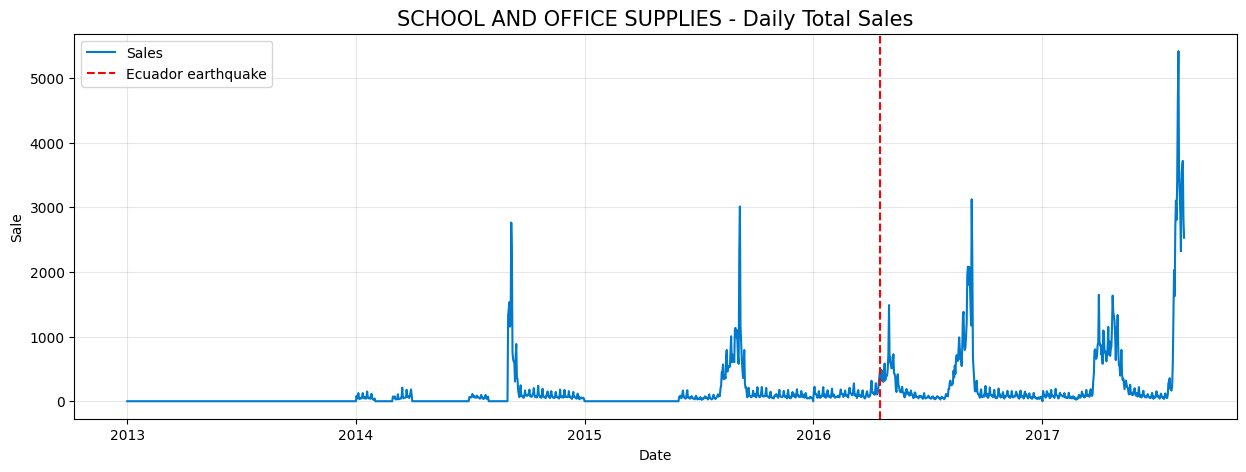

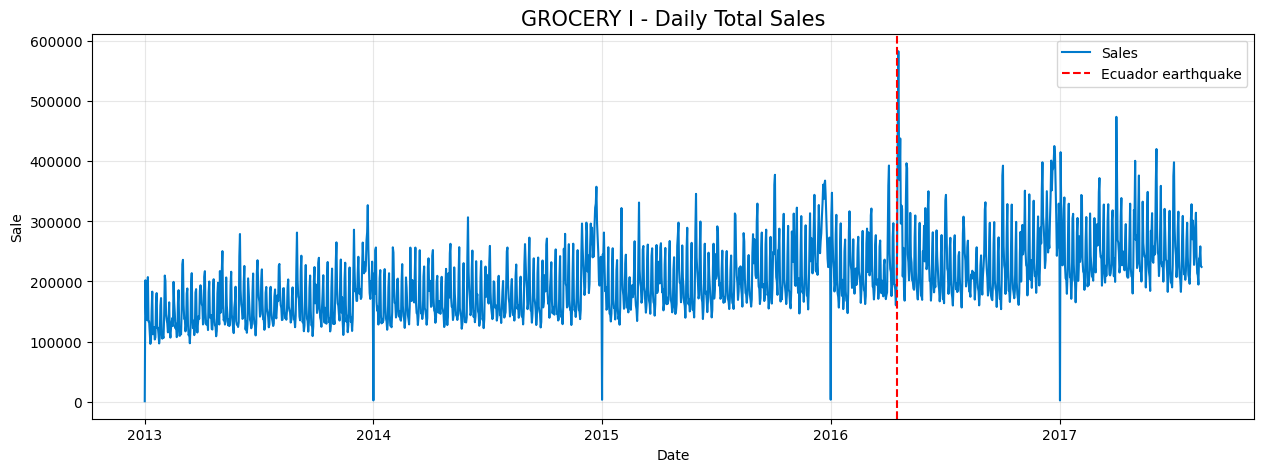

In [52]:
#Checking seasonality (school dates) and earthquake (as an outlier)
def plot_family_sales(family_name, data):
    family_data = data[data['family'] == family_name]
    daily_sales = family_data.groupby('date')['sales'].sum().reset_index()
    
    plt.figure(figsize=(15, 5))
    plt.plot(daily_sales['date'], daily_sales['sales'], label='Sales', color='#007acc')
    plt.title(f'{family_name} - Daily Total Sales', fontsize=15)
    plt.xlabel('Date')
    plt.ylabel('Sale')
    plt.grid(True, alpha=0.3)
    
    plt.axvline(pd.to_datetime('2016-04-16'), color='red', linestyle='--', label='Ecuador earthquake')
    plt.legend()
    plt.show()

plot_family_sales('SCHOOL AND OFFICE SUPPLIES', train)
plot_family_sales('GROCERY I', train)

#### Sales Trends and Outlier Analysis

The plots show daily sales for selected product families. For “SCHOOL AND OFFICE SUPPLIES,” a noticeable drop in sales around April 16, 2016, coincides with the Ecuador earthquake, highlighting an outlier event. Grocery sales (“GROCERY I”) remain relatively stable but show seasonal fluctuations. These insights help identify patterns, seasonality, and unusual events, which are important for feature engineering and improving forecast accuracy.

## Feature Engineering

In [53]:
def create_advanced_features(df):
    df=df.copy()
    
    #Payday
    df['is_payday'] = 0
    df.loc[(df['date'].dt.day == 15) | (df['date'].dt.is_month_end), 'is_payday'] = 1
    
    #Earthquake
    earthquake_start=pd.to_datetime('2016-04-16')
    earthquake_end=pd.to_datetime('2016-05-15')
    df['is_earthquake'] = 0
    df.loc[(df['date'] >= earthquake_start) & (df['date'] <= earthquake_end), 'is_earthquake'] = 1

    #Rolling Standard Deviation 
    df['sales_volatility_30'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
        lambda x: x.shift(16).rolling(window=30).std())
    #Rolling Mean of Promotion 
    df['promotion_intensity_30'] = df.groupby(['store_nbr', 'family'])['onpromotion'].transform(
        lambda x: x.shift(16).rolling(window=30).mean())
    
    # Lag features 
    # Shift(16)
    df['sales_lag_16'] = df.groupby(['store_nbr', 'family'])['sales'].shift(16)
    # Shift(30) 
    df['sales_lag_30'] = df.groupby(['store_nbr', 'family'])['sales'].shift(30)
    df['rolling_mean_30'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
        lambda x: x.shift(16).rolling(window=30).mean())
    
    return df

all_data=pd.concat([train, test], sort=False)
all_data=all_data.sort_values(['store_nbr', 'family', 'date']) 

all_data=create_advanced_features(all_data)

train_new=all_data[all_data['sales'].notnull()]
test_new=all_data[all_data['sales'].isnull()]

train_new=train_new.dropna(subset=['sales_lag_16']) 

outlier_start = pd.to_datetime('2016-04-16')
outlier_end = pd.to_datetime('2016-05-15')
train_new = train_new[(train_new['date'] < outlier_start) | (train_new['date'] > outlier_end)]

train_new.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,is_weekend,dcoilwtico,is_payday,is_earthquake,sales_volatility_30,promotion_intensity_30,sales_lag_16,sales_lag_30,rolling_mean_30
28512,28512,2013-01-17,1,AUTOMOTIVE,1.0,0,2013,1,17,3,0,95.49,0,0,NaN,NaN,0.0,NaN,NaN
30294,30294,2013-01-18,1,AUTOMOTIVE,0.0,0,2013,1,18,4,0,95.61,0,0,NaN,NaN,2.0,NaN,NaN
32076,32076,2013-01-19,1,AUTOMOTIVE,5.0,0,2013,1,19,5,1,95.73,0,0,NaN,NaN,3.0,NaN,NaN
33858,33858,2013-01-20,1,AUTOMOTIVE,3.0,0,2013,1,20,6,1,95.85,0,0,NaN,NaN,3.0,NaN,NaN
35640,35640,2013-01-21,1,AUTOMOTIVE,1.0,0,2013,1,21,0,0,95.97,0,0,NaN,NaN,5.0,NaN,NaN


In [54]:
cols_to_check = ['sales_lag_16', 'sales_lag_30', 'rolling_mean_30', 
                 'sales_volatility_30', 'promotion_intensity_30']
train_new = train_new.dropna(subset=cols_to_check)
print("Test NaN:", test_new[cols_to_check].isnull().sum().sum())

Test NaN: 0


In [55]:
y=np.log1p(train_new['sales'])
x=train_new.drop(['id', 'date', 'sales'], axis=1)

In [56]:
le=LabelEncoder()
categorical_cols=['family']
for col in categorical_cols:
    combined_data = pd.concat([x[col], test_new[col]], axis=0)
    le.fit(combined_data)
    x[col] = le.transform(x[col])
    test_new[col] = le.transform(test[col])

In [57]:
x_test=test_new.drop(['id', 'date', 'sales'], axis=1)

In [58]:
#Initialize an XGBoost regressor with tuned hyperparameters for improved training performance.
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=5000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    early_stopping_rounds=50)

In [59]:
#Split the data into training (Jan–Nov) and validation (Dec) using a 90/10 time-based split.
train_size = int(len(x) * 0.9)
x_train, x_val = x.iloc[:train_size], x.iloc[train_size:]
y_train, y_val = y.iloc[:train_size], y.iloc[train_size:]

In [60]:
#Train the XGBoost model and monitor performance on both training and validation sets.
model.fit(x_train, y_train,eval_set=[(x_train, y_train),(x_val, y_val)],verbose=100)

[0]	validation_0-rmse:2.56507	validation_1-rmse:2.62304
[100]	validation_0-rmse:0.61008	validation_1-rmse:0.58555
[200]	validation_0-rmse:0.55738	validation_1-rmse:0.54679
[300]	validation_0-rmse:0.53323	validation_1-rmse:0.53480
[400]	validation_0-rmse:0.51658	validation_1-rmse:0.52792
[500]	validation_0-rmse:0.50496	validation_1-rmse:0.52331
[550]	validation_0-rmse:0.50005	validation_1-rmse:0.52615


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

## Model Training  Summary

The XGBoost model was trained using the prepared training and validation sets. During training, the model’s performance was monitored using RMSE on both datasets. The error steadily decreased, showing that the model was effectively learning patterns in the data. After around 550 boosting rounds, the validation RMSE stopped improving, which triggered early stopping. This prevented overfitting and ensured the model retained the best-performing version from training.

In [61]:
#Convert log predictions back to real scale and clean negative or very small values.
predictions_log = model.predict(x_test)
predictions_real = np.expm1(predictions_log)
predictions_real = np.maximum(predictions_real, 0)
predictions_real[predictions_real < 0.1] = 0

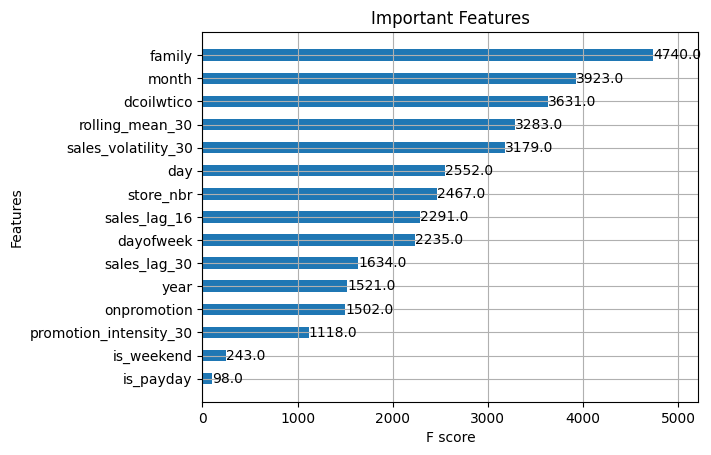

In [62]:
plot_importance(model, max_num_features=20, height=0.5, importance_type='weight', title='Important Features');

## Conclusion
Our submission achieved an RMSE of 0.53, indicating that the model’s predicted sales values are, on average, close to the actual sales. This reflects reasonable accuracy while leaving some room for further improvement.

In [63]:
submission=pd.DataFrame({'id': test_new['id'],'sales': predictions_real})
submission = submission.sort_values('id')
submission.to_csv('submission.csv', index=False)

## Authors
Romina Wogu & Ogunsola Mercy